In [1]:
from pisces.experiments import evaluate_mo_on_data_set, MOResUNetPretrained
from pisces.experiments import DataSetObject


sets = DataSetObject.find_data_sets("../data_sets")
hfd = sets['henry_ford_disordered']

In [2]:
mo = MOResUNetPretrained(sampling_hz=32)

results = evaluate_mo_on_data_set(mo, hfd)

parallel_execute: Using 16 of 16 cores (100%) for parallel preprocessing.
parallel_execute: This can cause memory or heat issues if  is too high; if you run into problems, call prepare_set_for_training() again with max_workers = -1, going more negative if needed. (See the docstring for more info.)
getting needed X, y for AWS002
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS001
getting needed X, y for AWS008
getting needed X, y for AWS007
getting needed X, y for AWS006
getting needed X, y for AWS003
getting needed X, y for AWS004
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019

/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


getting needed X, y for AWS018
getting needed X, y for AWS019
getting needed X, y for AWS020
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS021
getting needed X, y for AWS022
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.015151500701904297
resampling to 32Hz (0.03125s) from 66 Hz (0.01515s)
getting needed X, y for AWS023
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS024
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS025
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X

/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS035
getting needed X, y for AWS036
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS037
getting needed X, y for AWS038
getting needed X, y for AWS039
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS040
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
1/1 [==============================] - 0s 499ms/step
Processing 1 of 37 (AWS001)... AUROC: 0.46068712300026665
1/1 [==============================] - 0s 139ms/step
Proces

In [3]:
evaluations_hf, mo_preprocessed_data_hf = results
mo_aucs_hf = [e["auc"] for e in evaluations_hf.values()]
mo_fprs_hf = [e["roc_curve"]["fprs"] for e in evaluations_hf.values()]
mo_tprs_hf = [e["roc_curve"]["tprs"] for e in evaluations_hf.values()]

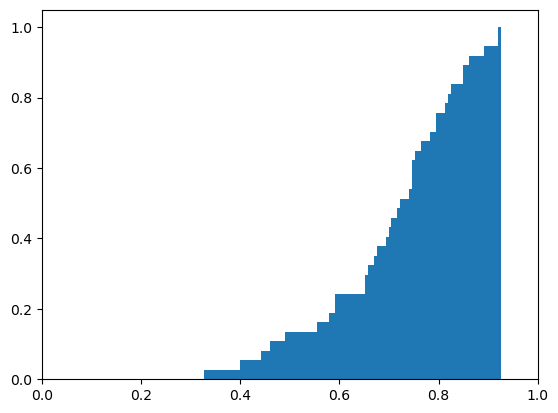

In [4]:

from pisces.utils import plot_scores_CDF


plot_scores_CDF(mo_aucs_hf)

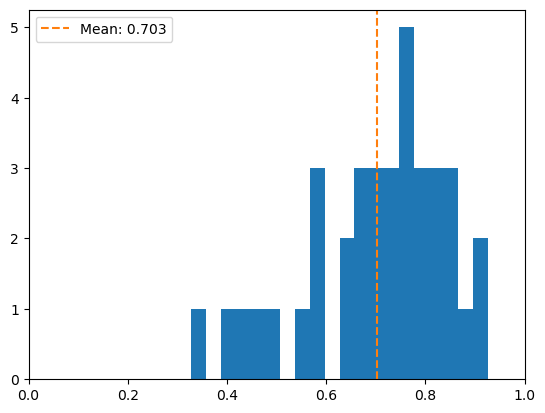

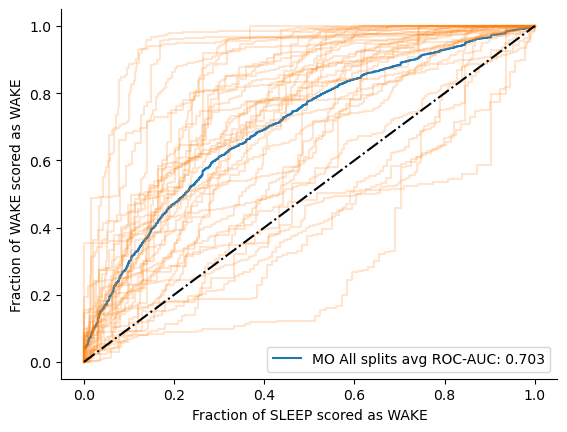

In [5]:

# y so terrible??
# probably timestamp/gap issues
# look at worst ones
from pisces.utils import add_rocs, plot_scores_PDF


plot_scores_PDF(mo_aucs_hf)

add_rocs(mo_fprs_hf, mo_tprs_hf, roc_group_name="MO")

In [7]:

from pisces.experiments import LeaveOneOutSplitter, SGDLogisticRegression, run_splits

loo = LeaveOneOutSplitter()
walch = sets['walch_et_al']

split_models, log_reg_preprocessed_data_walch, splits = run_splits(loo, walch, SGDLogisticRegression)

ID 7749105 not found in walch_et_al


0it [00:00, ?it/s]

31it [00:02, 10.60it/s]


In [9]:

from typing import Dict

from pisces.experiments import split_analysis


DATA_SET = hfd

log_reg_preprocessed_data_hf = [
    (d, DATA_SET.ids[i])
    for i in range(len(split_models))
    if (d := split_models[i].get_needed_X_y(DATA_SET, DATA_SET.ids[i])) is not None
]

log_reg_evaluations_hf: Dict[str, dict] = {}
for i, ((X, y), id) in enumerate(log_reg_preprocessed_data_hf):
    y_hat_proba = split_models[i].predict_probabilities(X)
    y_hat_sleep_proba = y_hat_proba[:, 1].reshape(-1,)
    y_prepped, _ = SGDLogisticRegression()._prepare_labels(y)
    try:
        analysis = split_analysis(y_prepped, y_hat_sleep_proba, balancing=False)
    except ValueError as e:
        print(f"Error processing {id}: {e}")
        continue
    # analysis = split_analysis(y, y_hat_proba)
    log_reg_evaluations_hf[id] = analysis
    print(f"Processing {i+1} of {len(log_reg_preprocessed_data_hf)} ({id})... AUROC: {analysis['auc']}")
log_reg_aucs_hf = [e["auc"] for e in log_reg_evaluations_hf.values()]
log_reg_fprs_hf = [e["roc_curve"]["fprs"] for e in log_reg_evaluations_hf.values()]
log_reg_tprs_hf = [e["roc_curve"]["tprs"] for e in log_reg_evaluations_hf.values()]


/Users/eric/Engineering/Work/pisces/pisces/experiments.py:241: UserWarning: Feature activity not found in henry_ford_disordered. Returning None.
  warnings.warn(f"Feature {feature} not found in {self.name}. Returning None.")
